# Construyendo el primer modelo predictivo

**Autor:** Jazna Meza Hidalgo

**Correo Electrónico:** ymeza@ubiobio.cl

**Fecha de Creación:** Septiembre de 2025  
**Versión:** 1.0  
  

---

## Descripción

Este notebook muestra la construcción del primer modelo predictivo de una variable continua, es decir, un `modelo de regresión`.


Se considera a `CRISP-DM` como la metodología de trabajo para desarrollar el proyecto.


Dentro del flujo de `CRISP-DM` se automatizan la fases de preparación y modelado a través del uso de `pipeline de scikit-learn`

---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.9. A continuación se listan las bibliotecas necesarias:

- pandas (>=1.1.0)
- numpy (1.26.4)

Para verificar si está instalado pandas, numpy o matplotlib ejecutar:

```bash
pip show pandas
```

```bash
pip show numpy
```

In [1]:
# Descargar el archivo y guardarlo en el entorno
!wget https://raw.githubusercontent.com/JaznaLaProfe/InteligenciaArtificial/master/data/inmuebles.csv

--2025-10-05 01:09:43--  https://raw.githubusercontent.com/JaznaLaProfe/InteligenciaArtificial/master/data/inmuebles.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190854 (186K) [text/plain]
Saving to: ‘inmuebles.csv’

inmuebles.csv       100%[===================>] 186.38K  --.-KB/s    in 0.02s   

2025-10-05 01:09:43 (7.39 MB/s) - ‘inmuebles.csv’ saved [190854/190854]



# Contexto del negocio

Una inmobiliaria busca mejorar la eficiencia de su equipo de ventas. Actualmente, los agentes inmobiliarios determinan el precio de venta de una propiedad de forma subjetiva, basándose en experiencia y comparación con inmuebles similares.

El problema:

Esto puede llevar a sobrevaloración (tiempo prolongado en el mercado) o subvaloración (pérdida de ingresos).

Además, se quiere estandarizar criterios y tener un modelo que pueda ser aplicado automáticamente a nuevas propiedades.

# Objetivo del proyecto

Construir un modelo predictivo que estime el precio de venta de una propiedad en función de sus características (superficie, ubicación, número de habitaciones, entre otras).

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*ELsvhb3RqyZS8phHxo6a3A.png)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [3]:
data = pd.read_csv('inmuebles.csv')
data.head()

,ID,Superficie_m2,Habitaciones,Baños,Antiguedad,Ubicacion,Estacionamientos,TieneTerraza,PrecioVenta
0,1,103,4,4,31.0,Alta,3.0,No,77691.0
1,2,148,3,2,35.0,Alta,0.0,No,80941.0
2,3,197,6,4,43.0,Media,2.0,No,89893.0
3,4,34,3,2,47.0,Media,3.0,Sí,41221.0
4,5,149,5,4,76.0,Baja,3.0,Sí,93710.0


# Fase 2 - Comprensión de los datos

## Cantidad observaciones y características

In [4]:
data.shape

(5000, 9)

## Análisis de calidad de los datos

### Existencia de duplicados

In [5]:
duplicados = data[data.duplicated(keep=False)]
duplicados

,ID,Superficie_m2,Habitaciones,Baños,Antiguedad,Ubicacion,Estacionamientos,TieneTerraza,PrecioVenta


✅ **Comentarios**

---

+ Se aprecia ausencia de filas duplicadas dentro del conjunto de datos.

### Inspección de datos nulos

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                5000 non-null   int64  
 1   Superficie_m2     5000 non-null   int64  
 2   Habitaciones      5000 non-null   int64  
 3   Baños             5000 non-null   int64  
 4   Antiguedad        4809 non-null   float64
 5   Ubicacion         5000 non-null   object 
 6   Estacionamientos  4726 non-null   float64
 7   TieneTerraza      5000 non-null   object 
 8   PrecioVenta       5000 non-null   float64
dtypes: float64(3), int64(4), object(2)
memory usage: 351.7+ KB


In [7]:
# Muestra una tabla con los % de nulos de cada columna
columnas_con_nulos = data.isna().sum()[data.isna().sum() > 0]
porcentaje_nulos = (columnas_con_nulos / data.shape[0]) * 100

resultado = pd.DataFrame({
    "Cantidad Nulos": columnas_con_nulos,
    "Porcentaje Nulos (%)": porcentaje_nulos
}).round(2)


resultado

,Cantidad Nulos,Porcentaje Nulos (%)
Antiguedad,191,3.82
Estacionamientos,274,5.48


✅ **Comentarios**

---

+ Se aprecia que hay 2 variables que contienen valores nulos y se deberán tratar ambas.

+ Para ambos casos, se debe revisar la existencia de atípicos para decidir por la técnica de reemplazo de nulos.

In [8]:
columnas_con_nulos = np.array(resultado.index)
columnas_con_nulos

array(['Antiguedad', 'Estacionamientos'], dtype=object)

### Análisis de consistencia

In [9]:
# Revisa los tipos de datos
data.dtypes

,0
ID,int64
Superficie_m2,int64
Habitaciones,int64
Baños,int64
Antiguedad,float64
Ubicacion,object
Estacionamientos,float64
TieneTerraza,object
PrecioVenta,float64


In [10]:
def ver_negativos(data : pd.DataFrame, columna : str) -> bool:
  """
  Verifica si una columna contiene valores negativos.
  """
  return np.sum(data[columna] < 0) > 0

In [11]:
columnas_a_revision = ["Superficie_m2", "Antiguedad", "Habitaciones", "Baños", "Estacionamientos", "PrecioVenta"]
for columna in columnas_a_revision:
  print(f"{columna :>20} -> {'Inconsistente' if ver_negativos(data, columna) else 'Consistente'}")

       Superficie_m2 -> Inconsistente
          Antiguedad -> Consistente
        Habitaciones -> Consistente
               Baños -> Consistente
    Estacionamientos -> Consistente
         PrecioVenta -> Inconsistente


In [12]:
data.Superficie_m2.describe()

,Superficie_m2
count,5000.000000
mean,123.534200
std,60.838178
min,-20.000000
25%,94.000000
50%,121.000000
75%,148.000000
max,1095.000000


In [13]:
print(f"Hay {np.sum(data.Superficie_m2 <= 0)} valores inconsistentes que representan el {np.sum(data.Superficie_m2 <= 0)/data.shape[0]:.4f}% de valores inconsistentes")

Hay 8 valores inconsistentes que representan el 0.0016% de valores inconsistentes


In [14]:
data.PrecioVenta.describe()

,PrecioVenta
count,5000.000000
mean,52646.625000
std,34524.835607
min,-50191.000000
25%,32240.500000
50%,51038.000000
75%,69064.750000
max,367269.000000


In [15]:
print(f"Hay {np.sum(data.PrecioVenta <= 0)} valores inconsistentes que representan el {np.sum(data.PrecioVenta < 0)/data.shape[0]:.2f}% de valores inconsistentes")

Hay 146 valores inconsistentes que representan el 0.03% de valores inconsistentes


✅ **Comentarios**

▶ Se aprecian valores inconsistentes en 2 de las variables: `PrecioVenta` y `Superficie`

▶ Los porcentajes de valores inconsistemtes son bajos por lo que se procede a eliminarlos porque están fuera del contexto del negocio, porque es imposible identificar la fuente del error se decide eliminar

In [16]:
data.TieneTerraza.unique()

array(['No', 'Sí'], dtype=object)

In [17]:
data.Ubicacion.unique()

array(['Alta', 'Media', 'Baja'], dtype=object)

### Existencia de valores atípicos

In [18]:
def buscar_atipicos(data : pd.DataFrame, columna : str) -> pd.DataFrame:
  """
  Busca valores atípicos en una columna.
  """
  # Calcular los límites
  Q1 = data[columna].quantile(0.25)
  Q3 = data[columna].quantile(0.75)
  # Calcula rango intercuartilico
  IQR = Q3 - Q1
  limite_inferior = Q1 - 1.5 * IQR
  limite_superior = Q3 + 1.5 * IQR

  # Filtrar outliers
  return data[(data[columna] < limite_inferior) | (data[columna] > limite_superior)]

def obtener_cantidad_atipicos(data : pd.DataFrame, columnas : np.array) -> dict:
  """
  Obtiene la cantidad de atípicos por cada columna.
  """
  total_atipicos = {}
  for columna in data[columnas]:
    atipicos = buscar_atipicos(data, columna)
    total_atipicos[columna] = atipicos.shape[0]
  return total_atipicos

In [19]:
atipicos_por_columna = obtener_cantidad_atipicos(data, data.describe().columns)
pd.DataFrame(atipicos_por_columna, index=["Cantidad"]).T

,Cantidad
ID,0
Superficie_m2,60
Habitaciones,0
Baños,0
Antiguedad,0
Estacionamientos,0
PrecioVenta,83


✅ **Comentarios**

---

▶ Dos variables presentan atípicos

#### `Superficie`

In [20]:
# Visualiza algunos atípicos
buscar_atipicos(data, "Superficie_m2").head()

,ID,Superficie_m2,Habitaciones,Baños,Antiguedad,Ubicacion,Estacionamientos,TieneTerraza,PrecioVenta
80,81,-20,2,1,51.0,Alta,2.0,Sí,31578.0
309,310,246,1,2,58.0,Baja,3.0,Sí,-25060.0
541,542,232,2,3,3.0,Media,2.0,No,18467.0
659,660,239,5,1,64.0,Baja,0.0,No,48143.0
684,685,9,4,1,52.0,Alta,2.0,Sí,75443.0


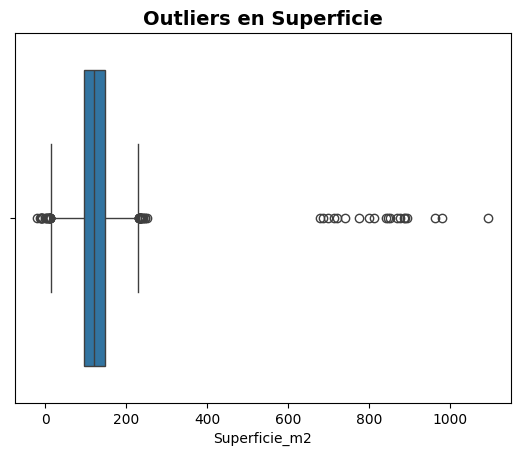

In [21]:
# Visualización de outliers en superficie
sb.boxplot(x=data["Superficie_m2"])
plt.title("Outliers en Superficie", fontsize=14, fontweight="bold")
plt.show()

## Análisis de datos

### Variable objetivo `PrecioVenta`

In [22]:
data.PrecioVenta.describe()

,PrecioVenta
count,5000.000000
mean,52646.625000
std,34524.835607
min,-50191.000000
25%,32240.500000
50%,51038.000000
75%,69064.750000
max,367269.000000


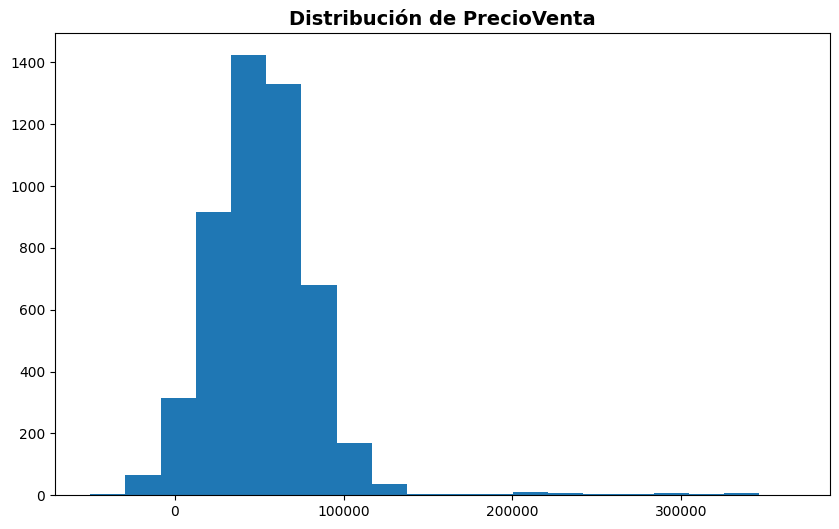

In [23]:
data.PrecioVenta.hist(bins=20, figsize=(10,6), grid=False)
plt.title("Distribución de PrecioVenta", fontsize=14, fontweight="bold")
plt.show()

### Variables candidatas a ser predictoras

In [24]:
data.Baños.describe()

,Baños
count,5000.000000
mean,2.504200
std,1.119926
min,1.000000
25%,1.000000
50%,3.000000
75%,4.000000
max,4.000000


✅ **Comentarios**

---

▶ En promedio, las viviendas tienen entre 2 y 3 baños.

▶ Las viviendas con mayor cantidad de baños tienen 4 baños.

▶ El 50% de las viviendas tienen 3 o menos baños.


# Fase 3 - Preparación de datos

## Elimina inconsistencias

In [25]:
# Detectar inconsistencias
inconsistentes = data[(data["Superficie_m2"] <= 0) | (data["PrecioVenta"] <= 0)]
print("Registros inconsistentes encontrados:")
display(inconsistentes)

Registros inconsistentes encontrados:


,ID,Superficie_m2,Habitaciones,Baños,Antiguedad,Ubicacion,Estacionamientos,TieneTerraza,PrecioVenta
61,62,167,3,2,NaN,Baja,2.0,No,-6459.0
71,72,103,3,4,73.0,Media,2.0,No,-15839.0
80,81,-20,2,1,51.0,Alta,2.0,Sí,31578.0
114,115,190,2,1,41.0,Baja,1.0,No,-4140.0
168,169,123,3,1,54.0,Baja,0.0,No,-402.0
...,...,...,...,...,...,...,...,...,...
4877,4878,148,2,1,46.0,Media,0.0,No,-575.0
4915,4916,157,1,1,75.0,Media,3.0,Sí,-5814.0
4919,4920,115,2,1,56.0,Baja,3.0,No,-7914.0
4920,4921,115,2,2,65.0,Media,3.0,No,-14323.0


In [26]:
# Opción 1: Eliminar inconsistencias
data_final = data[(data["Superficie_m2"] > 0) & (data["PrecioVenta"] > 0)]

# Opción 2 (solo si sabes que fue error de signo): corregir
# data["Superficie_m2"] = data["Superficie_m2"].abs()
# data["PrecioVenta"] = data["PrecioVenta"].abs()

In [27]:
print(f"Se han eliminado el {inconsistentes.shape[0]/data.shape[0]:.2f}% de los registros por inconsistencias")

Se han eliminado el 0.03% de los registros por inconsistencias


## Descarta columnas con nulo poder predictivo

In [28]:
# Elimina ID (no es predictivo)
data_final = data_final.drop(columns=["ID"])

✅ **Automatización de fases 3 y 4**

Las fases de preparación y modelamiento se van a automatizar a través del uso de un `pipeline`.

Ventajas de usar esta técnica:

+ Se puede encadenar imputación de nulos, codificación de variables categóricas y el modelo.

+ Permite hacer el mismo preprocesamiento en train y test sin errores.

+ Se vuelve **reutilizable** para producción o para predecir sobre nuevos datos.

Posible desventaja:

+ Todo queda encapsulado y no se ve fácilmente cómo quedaron los datos después de cada transformación.

In [29]:
# Recordar las columnas con nulos
data_final[columnas_con_nulos].isnull().sum()

,0
Antiguedad,190
Estacionamientos,270


In [30]:
# Variables
features_num = ["Superficie_m2", "Habitaciones", "Baños", "Antiguedad", "Estacionamientos"]
features_cat = ["Ubicacion", "TieneTerraza"]
target = "PrecioVenta"

X = data_final[features_num + features_cat]
y = data_final[target]

# Preprocesamiento numérico: imputación con mediana
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

# Preprocesamiento categórico: imputación + one-hot encoding
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

# Combina en un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, features_num),
        ("cat", categorical_transformer, features_cat)
    ]
)

In [31]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['Superficie_m2', 'Habitaciones', 'Baños',
                                  'Antiguedad', 'Estacionamientos']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['Ubicacion', 'TieneTerraza'])])

# Fase 4 - Modelamiento

In [32]:
# Calcula la matriz de correlaciones
correlaciones = data_final.corr(numeric_only=True)

# Ver correlación con la variable objetivo
correlacion_objetivo = correlaciones["PrecioVenta"].sort_values(ascending=False)

correlacion_objetivo

,PrecioVenta
PrecioVenta,1.000000
Baños,0.216374
Habitaciones,0.206255
Superficie_m2,0.009056
Estacionamientos,-0.009534
Antiguedad,-0.165418


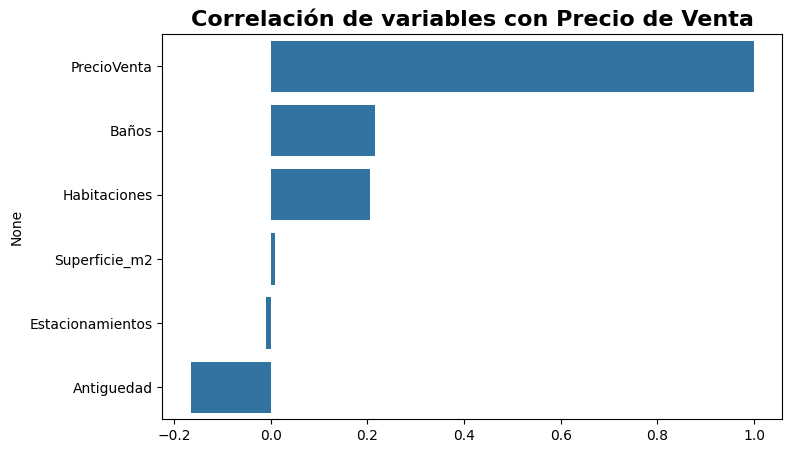

In [33]:
# Visualización de las correlaciones con el objetivo
plt.figure(figsize=(8,5))
sb.barplot(x=correlacion_objetivo.values, y=correlacion_objetivo.index)
plt.title("Correlación de variables con Precio de Venta",
          fontsize=16, fontweight="bold")
plt.show()

In [34]:
# Crea el pipeline final (preprocesamiento + modelo)
modelo = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# División train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=29)

# Entrenamiento
modelo.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Superficie_m2',
                                                   'Habitaciones', 'Baños',
                                                   'Antiguedad',
                                                   'Estacionamientos']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Ubicacion',
                                                   'TieneTerraza'])])),
                ('regressor', LinearRegression())])

In [35]:
# Variables con las cuales fue entrenado el modelo
modelo.feature_names_in_

array(['Superficie_m2', 'Habitaciones', 'Baños', 'Antiguedad',
       'Estacionamientos', 'Ubicacion', 'TieneTerraza'], dtype=object)

❓ **¿Cómo se puede visualizar el estado de la transformación?**

In [36]:
# Tomar solo el preprocesamiento (sin el modelo)
X_transformed = modelo.named_steps["preprocessor"].transform(X)

# Convertir a DataFrame para verlo con nombres de columnas
feature_names = modelo.named_steps["preprocessor"].get_feature_names_out()
X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)
X_transformed_df.head()


,num__Superficie_m2,num__Habitaciones,num__Baños,num__Antiguedad,num__Estacionamientos,cat__Ubicacion_Baja,cat__Ubicacion_Media,cat__TieneTerraza_Sí
0,103.0,4.0,4.0,31.0,3.0,0.0,0.0,0.0
1,148.0,3.0,2.0,35.0,0.0,0.0,0.0,0.0
2,197.0,6.0,4.0,43.0,2.0,0.0,1.0,0.0
3,34.0,3.0,2.0,47.0,3.0,0.0,1.0,1.0
4,149.0,5.0,4.0,76.0,3.0,1.0,0.0,1.0


In [37]:
pd.DataFrame(X).isnull().sum()

,0
Superficie_m2,0
Habitaciones,0
Baños,0
Antiguedad,190
Estacionamientos,270
Ubicacion,0
TieneTerraza,0


In [38]:
X_transformed_df.isnull().sum()

,0
num__Superficie_m2,0
num__Habitaciones,0
num__Baños,0
num__Antiguedad,0
num__Estacionamientos,0
cat__Ubicacion_Baja,0
cat__Ubicacion_Media,0
cat__TieneTerraza_Sí,0


✅ **Comentarios**

▶ Se comprueba que la tarea de tratamiento de nulos se llevó a cabo con éxito, porque ya no se aprecian nulos

# Fase 5 - Evaluación

In [39]:
# Funciones para ayudar con la interpretación de las métricas
def interpretacion(algoritmo : str, score : float, contexto : str, caracteristicas : np.array = None):
  """
  Genera la interpretación del rendimiento del modelo
  """
  if not caracteristicas == None:
    return f"""Modelo de regresión {algoritmo}
    {score :.2%} de la variabilidad en {contexto} se puede explicar utilizando: {caracteristicas.values}."""
  else:
    return f"""Modelo de regresión {algoritmo}
      {score :.2%} de la variabilidad en {contexto} se puede explicar utilizando las variables independientes"""

def mae_interpretacion(value : float, contexto : str, modelo : str = "Modelo") -> str:
  """
  Genera la interpretación del MAE
  """
  return f"El modelo '{modelo}' pudo predecir {contexto} en el conjunto de prueba con un error de ± $ {value:.2f} del valor real."

def msle_interpretacion(value : float, contexto : str, modelo : str = "Modelo") -> str:
  """
  Genera la interpretación del MSLE
  """
  return f"El modelo '{modelo}' pudo predecir {contexto} en el conjunto de prueba con un error de ± {value: .2%} del valor real."

In [40]:
# Predicciones
y_pred = modelo.predict(X_test)

# Evaluación
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
msle = mean_squared_log_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- Métricas del modelo ---")
print(f"{'RMSE' :<15}: {rmse:,.0f} USD")
print(f"{'R²' :<15}: {r2:.3f}")

print(f"{'MAE':<15}: {mae:,.0f} USD")
print(f"{'MSLE': <15}: {msle:.3f}")


--- Métricas del modelo ---
RMSE           : 28,143 USD
R²             : 0.183
MAE            : 17,469 USD
MSLE           : 0.392


In [41]:
# Guarda las métricas para comparar después con una posible mejora
resultado_inicial = {"RMSE" : rmse, "R2" : r2, "MAE" : mae, "MSLE" : msle}

In [42]:
nombre_modelo = "Predicción precio propiedad"
print(interpretacion(nombre_modelo, r2, "Precio venta"))

Modelo de regresión Predicción precio propiedad
      18.26% de la variabilidad en Precio venta se puede explicar utilizando las variables independientes


In [43]:
# Interpretación de las métricas
print(mae_interpretacion(mae, "PrecioVenta", nombre_modelo))
print(msle_interpretacion(msle, "PrecioVenta", nombre_modelo))

El modelo 'Predicción precio propiedad' pudo predecir PrecioVenta en el conjunto de prueba con un error de ± $ 17469.26 del valor real.
El modelo 'Predicción precio propiedad' pudo predecir PrecioVenta en el conjunto de prueba con un error de ±  39.21% del valor real.


In [44]:
# Obtiene una predicción con nuevos datos
nueva_propiedad = pd.DataFrame({
    "Superficie_m2": [150],
    "Habitaciones": [3],
    "Baños": [2],
    "Antiguedad": [10],
    "Estacionamientos": [1],
    "Ubicacion": ["Media"],
    "TieneTerraza": ["Sí"]
})

precio_estimado = modelo.predict(nueva_propiedad)[0]
print(f"\nPrecio estimado para nueva propiedad: {precio_estimado:,.0f} USD")


Precio estimado para nueva propiedad: 54,624 USD


In [45]:
# Guarda las métricas para comparar con alguna variante
resultado_base = {"RMSE" : rmse, "R2" : r2, "MAE" : mae, "MSLE" : msle}



---



# ⭐ ⭐ Variante del modelo ⭐ ⭐

In [46]:
def mas_correlacionadas(correlacion_objetivo :pd.Series, k_mejor_positiva : int,
                        k_mejor_negativa : int) -> np.array:
  """
  Obtiene las k variables más correlacionadas (positiva y negativamente)
  con la variable objetivo, a partir de una serie de correlaciones
  ordenada de mayor a menor.
  """
  # Top k positivas (ignorando la propia variable objetivo
  positivas = correlacion_objetivo.index[1:k_mejor_positiva+1]

  # Top k negativas (últimos elementos de la serie)
  negativas = correlacion_objetivo.index[-k_mejor_negativa:]

  return np.array(list(positivas) + list(negativas))

In [47]:
# Obtiene las variables con mejor correlación (positiva y negativa) con la variable objetivo
mejores_predictoras = mas_correlacionadas(correlacion_objetivo, 2, 1)
mejores_predictoras

array(['Baños', 'Habitaciones', 'Antiguedad'], dtype='<U12')

In [48]:
# Variables
features_num = mejores_predictoras
features_cat = [] # En este caso NO existen variables categóricas
target = "PrecioVenta"

X = data_final[features_num]
y = data_final[target]

# Preprocesamiento numérico: imputación con mediana
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

# Preprocesamiento categórico: imputación + one-hot encoding
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

# Combina en un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, features_num),
        ("cat", categorical_transformer, features_cat)
    ]
)

In [49]:
# Crea el pipeline final (preprocesamiento + modelo)
nuevo_modelo = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# División train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=29)

# Entrenamiento
nuevo_modelo.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  array(['Baños', 'Habitaciones', 'Antiguedad'], dtype='<U12')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  [])])),
                ('regressor', LinearRegression())])

In [50]:
# Tomar solo el preprocesamiento (sin el modelo)
X_transformed = nuevo_modelo.named_steps["preprocessor"].transform(X)

# Convertir a DataFrame para verlo con nombres de columnas
feature_names = nuevo_modelo.named_steps["preprocessor"].get_feature_names_out()
X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)
X_transformed_df.head()

,num__Baños,num__Habitaciones,num__Antiguedad
0,4.0,4.0,31.0
1,2.0,3.0,35.0
2,4.0,6.0,43.0
3,2.0,3.0,47.0
4,4.0,5.0,76.0


In [51]:
# Comprueba que el tratamiento de nulos (definido en el pipeline se realiza)
X_transformed_df.isnull().sum()

,0
num__Baños,0
num__Habitaciones,0
num__Antiguedad,0


In [52]:
# Predicciones
y_pred = nuevo_modelo.predict(X_test)

# Evaluación
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
msle = mean_squared_log_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- Métricas del modelo ---")
print(f"{'RMSE' :<15}: {rmse:,.0f} USD")
print(f"{'R²' :<15}: {r2:.3f}")

print(f"{'MAE':<15}: {mae:,.0f} USD")
print(f"{'MSLE': <15}: {msle:.3f}")


--- Métricas del modelo ---
RMSE           : 29,455 USD
R²             : 0.105
MAE            : 19,477 USD
MSLE           : 0.449


In [53]:
# Guarda las métricas para comparar con el modelo original
resultado_variante = {"RMSE" : rmse, "R2" : r2, "MAE" : mae, "MSLE" : msle}

In [54]:
# Obtiene una predicción con nuevos datos
nueva_propiedad = pd.DataFrame({
    "Habitaciones": [3],
    "Baños": [2],
    "Antiguedad": [10],
})

precio_estimado = nuevo_modelo.predict(nueva_propiedad)[0]
print(f"\nPrecio estimado para nueva propiedad: {precio_estimado:,.0f} USD")


Precio estimado para nueva propiedad: 56,119 USD


In [57]:
# Crea DataFrame con los resultados de las métricas
data_resultados = pd.DataFrame({
    "Métrica": list(resultado_inicial.keys()),
    "Modelo Original": list(resultado_base.values()),
    "Variante Modelo": list(resultado_variante.values())
})
data_resultados.round(2)

,Métrica,Modelo Original,Variante Modelo
0,RMSE,28142.88,29455.02
1,R2,0.18,0.10
2,MAE,17469.26,19477.15
3,MSLE,0.39,0.45


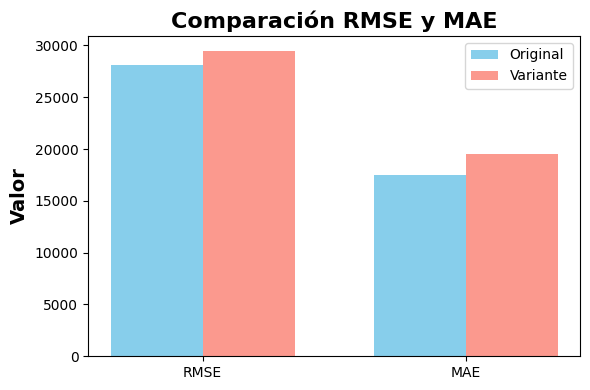

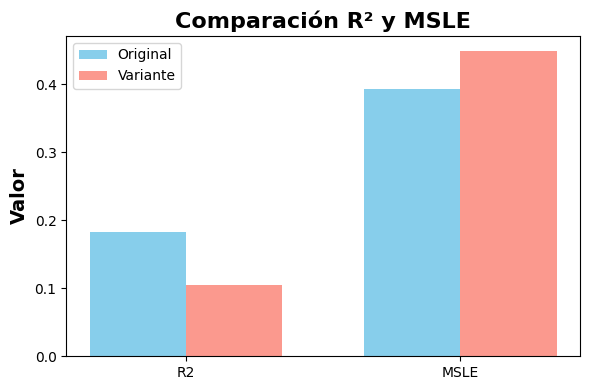

In [56]:
# Separa las métricas porque tienen escalas distintas
metricas_grandes = ["RMSE", "MAE"]
metricas_pequenas = ["R2", "MSLE"]

# Filtrar valores
valores_orig_grandes = [resultado_inicial[metrica] for metrica in metricas_grandes]
valores_mej_grandes  = [resultado_variante[metrica] for metrica in metricas_grandes]

valores_orig_peq = [resultado_inicial[metrica] for metrica in metricas_pequenas]
valores_mej_peq  = [resultado_variante[metrica] for metrica in metricas_pequenas]

x_grandes = np.arange(len(metricas_grandes))
x_peq = np.arange(len(metricas_pequenas))
width = 0.35

# Gráfico RMSE y MAE
plt.figure(figsize=(6,4))
plt.bar(x_grandes - width/2, valores_orig_grandes, width, label="Original", color="skyblue")
plt.bar(x_grandes + width/2, valores_mej_grandes, width, label="Variante", color="salmon", alpha=0.8)
plt.xticks(x_grandes, metricas_grandes)
plt.ylabel("Valor", fontsize=14, fontweight="bold")
plt.title("Comparación RMSE y MAE", fontsize=16, fontweight="bold")
plt.legend()
plt.tight_layout()
plt.show()

# Gráfico R2 y MSLE
plt.figure(figsize=(6,4))
plt.bar(x_peq - width/2, valores_orig_peq, width, label="Original", color="skyblue")
plt.bar(x_peq + width/2, valores_mej_peq, width, label="Variante", color="salmon", alpha=0.8)
plt.xticks(x_peq, metricas_pequenas)
plt.ylabel("Valor", fontsize=14, fontweight="bold")
plt.title("Comparación R² y MSLE", fontsize=16, fontweight="bold")
plt.legend()
plt.tight_layout()
plt.show()

✅ **Comentarios**

▶ `RMSE` y `MAE` más altos en la variante del modelo muestran que las predicciones son menos precisas.

▶ $R^2$ más bajo indica que la variante del modelooriginal explica menos variabilidad del precio de la vivienda.

**▶ En conclusión, seleccionar las variables con correlaciones más altas, en este caso, no necesariamente asegura un mejor resultado.**
